# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 2

### Import

In [6]:
# # Primeiro, realizamos a instalação do scikit-learn versão 0.20.0 no Kernel deste notebook:
# !pip install numpy==1.16.4 --upgrade
# !pip install pandas==0.24.2 --upgrade
# !pip install scikit-learn==0.20.3 --upgrade
# !pip install lightgbm
# !pip install xgboost
# !pip install scikit-optimize

In [7]:
import json
import requests
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import lightgbm as lgbm

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)

In [8]:
# << INSIRA O DATASET COMO UM DATAFRAME PANDAS NESTA CÉLULA >>
import types
import pandas as pd

df_data_1 = pd.read_csv("../Data/dataset_desafio_2.csv")
df_data_1.head()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


### Preprocessing

In [9]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
MATRICULA         20000 non-null int64
NOME              20000 non-null object
REPROVACOES_DE    20000 non-null int64
REPROVACOES_EM    20000 non-null int64
REPROVACOES_MF    20000 non-null int64
REPROVACOES_GO    20000 non-null int64
NOTA_DE           20000 non-null float64
NOTA_EM           20000 non-null float64
NOTA_MF           20000 non-null float64
NOTA_GO           16284 non-null float64
INGLES            16372 non-null float64
H_AULA_PRES       20000 non-null int64
TAREFAS_ONLINE    20000 non-null int64
FALTAS            20000 non-null int64
PERFIL            20000 non-null object
dtypes: float64(5), int64(8), object(2)
memory usage: 2.3+ MB


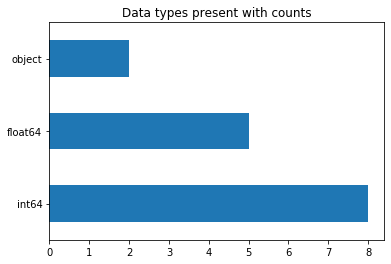

In [10]:
#Check the data types
df_data_1.dtypes.value_counts().plot(kind='barh')
plt.title('Data types present with counts')
plt.show()

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

#### Declarando a Pipeline

Após a importação das transformações personalizadas como um pacote Python, podemos partir para a declaração da nossa Pipeline.

O processo é bem semelhante ao realizado na primeira etapa, porém com algumas diferenças importantes, então preste bem atenção!

A Pipeline exemplo possui três estágios: 

    - remover a coluna "NOME"
    - imputar "zeros" em todos os valores faltantes
    - inserir os dados pré-processados como entrada em um modelo treinado
    
Relembrando, a entrada desta Pipeline será o conjunto cru de dados fornecido exceto a coluna "LABELS" (variável-alvo a ser determinada pelo modelo).

Teremos então 17 valores de entrada **na PIPELINE** (no modelo serão 16 entradas, pois a coluna NAME será removida no primeiro estágio após a transformação DropColumn).

    MATRICULA       - número de quatro algarismos único para cada estudante
    NOME            - nome completo do estudante
    FALTAS_DE       - número de faltas na disciplina de ``Direito Empresarial``
    FALTAS_EM       - número de faltas na disciplina de ``Empreendedorismo``
    FALTAS_MF       - número de faltas na disciplina de ``Matemática Financeira``
    MEDIA_DE        - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    MEDIA_EM        - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    MEDIA_MF        - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    HRS_ESTUDO_DE   - horas de estudo particular na disciplina de ``Direito Empresarial``
    HRS_ESTUDO_EM   - horas de estudo particular na disciplina de ``Empreendedorismo``
    HRS_ESTUDO_MF   - horas de estudo particular na disciplina de ``Matemática Financeira``
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    LIVROS_TEXTO    - quantidade de livros e textos acessados pelo aluno no sistema da universidade
    AULAS_AO_VIVO   - horas de aulas ao vivo presenciadas pelo aluno (total em todas as disciplinas)
    EXERCICIOS      - número de exercícios realizados pelo estudante (total em todas as disciplinas) no sistema da universidade

A saída da Pipeline será um valor estimado para a coluna "LABELS".

In [12]:
# Criação de uma Transform personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=["NOME"]
)

In [13]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    "MATRICULA", "NOME", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
    "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_data_1[features]
y = df_data_1[target]

**ATENÇÃO!!**

A célula acima, embora muito parecida com a definição de features na primeira etapa deste desafio, possui uma grande diferença!

Nela está presente a coluna "NOME" como uma feature! Isso ocorre pois neste caso essas são as entradas da *PIPELINE*, e não do modelo.

In [14]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

Na célula abaixo é realizada a declaração de um objeto **Pipeline** do scikit-learn, onde é declarado o parâmetro *steps*, que nada mais é do que uma lista com as etapas da nossa pipeline:

    'remove_cols'     - transformação personalizada DropColumns
    'imputer'         - transformação embutida do scikit-learn para imputação de valores faltantes
    'dtc'             - um classificador via árvore de decisão
    
Note que passamos como passos as transformadas instanciadas anteriormente, sob nome `rm_columns` e `si`.

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
MATRICULA         20000 non-null int64
NOME              20000 non-null object
REPROVACOES_DE    20000 non-null int64
REPROVACOES_EM    20000 non-null int64
REPROVACOES_MF    20000 non-null int64
REPROVACOES_GO    20000 non-null int64
NOTA_DE           20000 non-null float64
NOTA_EM           20000 non-null float64
NOTA_MF           20000 non-null float64
NOTA_GO           16284 non-null float64
INGLES            16372 non-null float64
H_AULA_PRES       20000 non-null int64
TAREFAS_ONLINE    20000 non-null int64
FALTAS            20000 non-null int64
dtypes: float64(5), int64(8), object(1)
memory usage: 2.1+ MB


In [16]:
print("train size: ", len(X_train))
print("train size: ",len(X_test))

train size:  14000
train size:  6000


### LGBM sem tunning

In [17]:
# Criação de um objeto ``SimpleImputer``

si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
#     strategy = "most_frequent",
    verbose=0,
    copy=True
)


clf =  lgbm.LGBMClassifier()
# clf_xgb = XGBClassifier(verbose=1)

pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('imputer', si),
        ('clf', clf),
    ]
)

In [18]:
# Inicialização da Pipeline (pré-processamento e realização do treinamento do modelo)
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('remove_cols', DropColumns(columns=['NOME'])), ('imputer', SimpleImputer(copy=True, fill_value=0, missing_values=nan,
       strategy='constant', verbose=0)), ('clf', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=...0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [19]:
# Realização de teste cego no modelo criado
from sklearn.metrics import accuracy_score

# Acurácia alcançada pela árvore de decisão
y_pred = pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

Acurácia: 80.77%


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 DIFICULDADE       0.88      0.75      0.81      2111
      EXATAS       0.80      0.91      0.85      2455
   EXCELENTE       0.64      0.69      0.66       217
     HUMANAS       0.77      0.93      0.84       937
   MUITO_BOM       0.29      0.07      0.11       280

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.68      0.67      0.66      6000
weighted avg       0.79      0.81      0.79      6000



## Tunando LGBM com Bayesian Optimization

In [21]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.space import Real, Integer

# The list of hyper-parameters we want to optimize
space = [
    Integer(2, 256, name="num_leaves"),
    Real(10 ** -3, 0.5, "log-uniform", name="learning_rate"),
    Integer(1, 256, name="min_child_samples"),
    Real(0.05, 1.00, name="subsample"),
    Real(0.1, 1.00, name="colsample_bytree"),
]

params_names = [dim.name for dim in space]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)
    pipeline = Pipeline(
        steps=[
            ('remove_cols', rm_columns),
            ('imputer', si),
            ('clf', clf),
        ]
    )

    return -np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1,
                            scoring="accuracy"))

# do bayesian optimization

clf = lgbm.LGBMClassifier(random_state=42)
# clf = XGBClassifier()

result_gp = gp_minimize(
    objective, space, random_state=42, verbose=1, n_calls=10, n_random_starts=5
)

# get best params and make the best classifier
best_params = dict(zip(params_names, result_gp.x))

# best_clf = XGBClassifier(**best_params)
best_clf = lgbm.LGBMClassifier(**best_params)

Iteration No: 1 started. Evaluating function at random point.


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
best_clf

In [ ]:
%matplotlib inline

In [ ]:
from skopt.plots import plot_convergence, plot_evaluations

plot_convergence(result_gp)
plt.show()

In [ ]:
plot_evaluations(result_gp)
plt.show()

In [ ]:
best_pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('imputer', si),
        ('clf', best_clf),
    ]
)
best_pipeline.fit(X_train, y_train.values.ravel())

y_pred = best_pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

### XgBoost

In [ ]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.space import Real, Integer

# The list of hyper-parameters we want to optimize
space = [
    Integer(2, 256, name="num_leaves"),
    Real(10 ** -3, 0.5, "log-uniform", name="learning_rate"),
    Integer(1, 256, name="min_child_samples"),
    Real(0.05, 1.00, name="subsample"),
    Real(0.1, 1.00, name="colsample_bytree"),
]


params_names = [dim.name for dim in space]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)
    pipeline = Pipeline(
        steps=[
            ('remove_cols', rm_columns),
            ('imputer', si),
            ('clf', clf),
        ]
    )

    return -np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1,
                            scoring="accuracy"))

# do bayesian optimization

clf = XGBClassifier()

result_gp = gp_minimize(
    objective, space, random_state=42, verbose=1, n_calls=10, n_random_starts=5
)

# get best params and make the best classifier
best_params = dict(zip(params_names, result_gp.x))

best_clf = XGBClassifier(**best_params)

In [ ]:
best_pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('imputer', si),
        ('clf', best_clf),
    ]
)
best_pipeline.fit(X_train, y_train.values.ravel())

y_pred = best_pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

In [ ]:
plot_evaluations(result_gp)
plt.show()

### Encapsulando uma Pipeline personalizada no Watson Machine Learning

#### Estabelecendo conexão entre o cliente Python do WML e a sua instância do serviço na nuvem

In [ ]:
# Biblioteca Python com implementação de um cliente HTTP para a API do WML
from watson_machine_learning_client import WatsonMachineLearningAPIClient

As próximas células irão realizar o deploy da pipeline declarada neste notebook no WML. Só prossiga se você já está satisfeito com seu modelo e acha que já é a hora de fazer o deploy da sua solução.

Cole as credenciais de sua instância do Watson Machine Learning na variável na célula abaixo.

É importante que a variável que contém os valores tenha o nome de ``wml_credentials`` para que as próximas células deste notebook executem corretamente.

In [ ]:
wml_credentials = {
  "apikey": "",
  "iam_apikey_description": "",
  "iam_apikey_name": "",
  "iam_role_crn": "",
  "iam_serviceid_crn": "",
  "instance_id": "",
  "url": ""
}

In [ ]:
# Instanciando um objeto cliente do Watson Machine Learning a partir das credenciais fornecidas

clientWML = WatsonMachineLearningAPIClient(wml_credentials)

In [ ]:
# Extraindo detalhes da sua instância do Watson Machine Learning

instance_details = clientWML.service_instance.get_details()
print(json.dumps(instance_details, indent=4))

**ATENÇÃO!!**

Fique atento para os limites de consumo de sua instância do Watson Machine Learning!

Caso você expire a camada grátis, não será possível avaliar seu modelo (pois é necessária a realização de algumas chamadas de API que consomem predições!)

#### Listando todos os artefatos armazenados no seu WML

Para listar todos os artefatos armazenados em seu Watson Machine Learning, você pode usar a seguinte função:

    clientWML.repository.list()

In [ ]:
# Listando todos os artefatos atualmente armazenados na sua instância do WML

clientWML.repository.list()

No plano LITE do Watson Machine Learning só é permitido o deploy de um único modelo por vez. Se for o caso de você já possuir um modelo online na sua instância, você pode apagá-lo utilizando o método clientWML.repository.delete():

    artifact_guid = "359c8951-d2fe-4063-8706-cc06b32d5e0d"
    clientWML.repository.delete(artifact_guid)

#### Criando uma nova definição de pacote Python personalizado no WML

O primeiro passo para realizar seu deploy é armazenar o código das transformações personalizadas criadas por você.

Para essa etapa precisamos apenas do arquivo .zip do pacote criado (que já possuimos carregado no Kernel!)

In [ ]:
# Definição de metadados do nosso pacote com as Transforms personalizadas
pkg_meta = {
    clientWML.runtimes.LibraryMetaNames.NAME: "my_custom_sklearn_transform_1",
    clientWML.runtimes.LibraryMetaNames.DESCRIPTION: "A custom sklearn transform",
    clientWML.runtimes.LibraryMetaNames.FILEPATH: "sklearn_transforms.zip",  # Note que estamos utilizando o .zip criado anteriormente!
    clientWML.runtimes.LibraryMetaNames.VERSION: "1.0",
    clientWML.runtimes.LibraryMetaNames.PLATFORM: { "name": "python", "versions": ["3.6"] }
}
custom_package_details = clientWML.runtimes.store_library( pkg_meta )
custom_package_uid = clientWML.runtimes.get_library_uid( custom_package_details )

print("\n Lista de artefatos de runtime armazenados no WML:")
clientWML.repository.list()

#### Criando uma nova definição de runtime Python personalizado no WML

O segundo passo é armazenar uma definição de runtime Python para utilizar a nossa biblioteca personalizada.

Isso pode ser feito da seguinte forma:

In [ ]:
runtime_meta = {
    clientWML.runtimes.ConfigurationMetaNames.NAME: "my_custom_wml_runtime_1",
    clientWML.runtimes.ConfigurationMetaNames.DESCRIPTION: "A Python runtime with custom sklearn Transforms",
    clientWML.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.6"
    },
    clientWML.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [ custom_package_uid ]
}
runtime_details = clientWML.runtimes.store( runtime_meta )
custom_runtime_uid = clientWML.runtimes.get_uid( runtime_details )

print("\n Detalhes do runtime armazenado:")
print(json.dumps(runtime_details, indent=4))

In [ ]:
# Listando todos runtimes armazenados no seu WML:
clientWML.runtimes.list()

#### Criando uma nova definição de Pipeline personalizada no WML

Finalmente iremos criar uma definição (metadados) para a nossa Pipeline ser hospedada no WML.

Definimos como parâmetros um nome para o artefato e o ID do runtime criado anteriormente.

In [ ]:
model_meta = {
    clientWML.repository.ModelMetaNames.NAME: 'desafio-2-mbtc2020-pipeline-1',
    clientWML.repository.ModelMetaNames.DESCRIPTION: "my pipeline for submission",
    clientWML.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid
}

Em seguida chamamos o método para armazenar a nova definição:

In [ ]:
# Função para armazenar uma definição de Pipeline no WML
stored_model_details = clientWML.repository.store_model(
    model=my_pipeline,  # `my_pipeline` é a variável criada anteriormente e contém nossa Pipeline já treinada :)
    meta_props=model_meta,  # Metadados definidos na célula anterior
    training_data=None  # Não altere esse parâmetro
)

print("\n Lista de artefatos armazenados no WML:")
clientWML.repository.list()

# Detalhes do modelo hospedado no Watson Machine Learning
print("\n Metadados do modelo armazenado:")
print(json.dumps(stored_model_details, indent=4))

#### Realizando o deployment do seu modelo para consumo imediato por outras aplicações

In [ ]:
# O deployment do modelo é finalmente realizado por meio do método ``deployments.create()``

model_deployment_details = clientWML.deployments.create(
    artifact_uid=stored_model_details["metadata"]["guid"],  # Não altere esse parâmetro
    name="desafio-2-mbtc2020-deployment-1",
    description="Solução do desafio 2 - MBTC",
    asynchronous=False,  # Não altere esse parâmetro
    deployment_type='online',  # Não altere esse parâmetro
    deployment_format='Core ML',  # Não altere esse parâmetro
    meta_props=model_meta  # Não altere esse parâmetro
)

#### Testando um modelo hospedado no Watson Machine Learning

In [ ]:
# Recuperando a URL endpoint do modelo hospedado na célula anterior

model_endpoint_url = clientWML.deployments.get_scoring_url(model_deployment_details)
print("A URL de chamada da sua API é: {}".format(model_endpoint_url))

In [ ]:
# Detalhes do deployment realizado

deployment_details = clientWML.deployments.get_details(
    deployment_uid=model_deployment_details["metadata"]["guid"]  # esse é o ID do seu deployment!
)

print("Metadados do deployment realizado: \n")
print(json.dumps(deployment_details, indent=4))

In [ ]:
scoring_payload = {
    'fields': [
        "MATRICULA", "NOME", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
        "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
        "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
    ],
    'values': [
        [
            513949,"Marli Quésia de Oliveira",1,1,1,1,4.3,4.0,3.1,4.9,0,3,4,3,
        ]
    ]
}

print("\n Payload de dados a ser classificada:")
print(json.dumps(scoring_payload, indent=4))

In [ ]:
result = clientWML.deployments.score(
    model_endpoint_url,
    scoring_payload
)

print("\n Resultados:")
print(json.dumps(result, indent=4))

<hr>

## Parabéns! 

Se tudo foi executado sem erros, você já tem um classificador baseado em machine learning encapsulado como uma API REST!

Para testar a sua solução integrada com um assistente virtual e realizar a submissão, acesse a página:

https://uninassau.maratona.dev

Você irá precisar da endpoint url do seu modelo e das credenciais do WML :)